# Training Models

In [1]:
#Importing Libraries
import sys
import os
import numpy as np
import pandas as pd
import mlflow
import os

In [2]:
#Jupyter Notebook Settings
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import plot_tree
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.model_selection import cross_val_score


In [4]:
os.getcwd()


'c:\\Users\\milky\\Desktop\\10Academy\\Week 2\\abtest-mlops\\notebooks'

In [5]:
#importing local scripts
#Adding scripts path
sys.path.append(os.path.abspath(os.path.join('..')))
#importing data_manipulator script
from scripts.model_info_extractor import *
from scripts.ml_modelling_utils import *

## Importing and Fixing Data

In [6]:
#Importing the collected Data
path = 'data/AdSmartABdata.csv'
repo = 'https://github.com/DePacifier/abtest-mlops'
all_dfs = import_all_data_using_tagslist(path=path, repo=repo, tags=[
                                         'chrome-mobile', 'chrome-mobile-view', 'facebook', 'samsung-internet', 'platform-6'])


In [7]:
all_dfs['chrome-mobile'].head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,378645d2-f8cf-43c0-b1be-e699d846e596,control,2020-07-04,6,Generic Smartphone,6,Chrome Mobile,0
1,ef334830-f200-4c1b-aea2-b01b96ca0950,exposed,2020-07-03,12,Generic Smartphone,6,Chrome Mobile,0
2,49e7690d-4825-499c-9553-756af3198a10,control,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,1
3,80b9fecc-ef23-4896-bd43-b81c074f49c3,control,2020-07-09,17,Generic Smartphone,6,Chrome Mobile,1
4,3dd09b49-9b11-45bd-ab0d-e279a8e5edc7,exposed,2020-07-03,0,Generic Smartphone,6,Chrome Mobile,0


In [8]:
# Spliting the date column to year, month and day columns and removing it
all_dfs_date_fixed = split_date_to_numbers(all_dfs, 'date')
all_dfs_date_fixed['chrome-mobile'].head(5)

,auction_id,experiment,hour,device_make,platform_os,browser,response,year,month,day
0,378645d2-f8cf-43c0-b1be-e699d846e596,control,6,Generic Smartphone,6,Chrome Mobile,0,2020,7,4
1,ef334830-f200-4c1b-aea2-b01b96ca0950,exposed,12,Generic Smartphone,6,Chrome Mobile,0,2020,7,3
2,49e7690d-4825-499c-9553-756af3198a10,control,10,Generic Smartphone,6,Chrome Mobile,1,2020,7,7
3,80b9fecc-ef23-4896-bd43-b81c074f49c3,control,17,Generic Smartphone,6,Chrome Mobile,1,2020,7,9
4,3dd09b49-9b11-45bd-ab0d-e279a8e5edc7,exposed,0,Generic Smartphone,6,Chrome Mobile,0,2020,7,3


In [9]:
#drop columns from each data, the grouping column b/c its a univalue column
#We have 5 dataframes of which 4 are grouped based on browser and 1 based on platform
for i in all_dfs_date_fixed:
    if(i != "platform-6"):
        all_dfs_date_fixed[i].drop('browser', axis=1, inplace=True)
    else:
        all_dfs_date_fixed[i].drop('platform_os', axis=1, inplace=True)

In [10]:

data_type_fixed_dfs = change_columns_to_numbers(all_dfs_date_fixed, ['experiment', 'device_make', 'browser'])
data_type_fixed_dfs['platform-6'].sample(5)


,auction_id,experiment,hour,device_make,browser,response,year,month,day
1093,0cd88b3e-92fe-4a4b-b0a4-77587b33bc2e,0,15,1,3,0,2020,7,3
663,5aacbe2c-080f-4542-a289-2f147fa71606,1,9,13,1,0,2020,7,3
447,7cff2a18-9c03-40c2-838d-ae4921a5c0ba,1,7,13,2,1,2020,7,3
37,b7cc440c-0bcc-415d-a312-b5385ffa4583,1,10,13,1,0,2020,7,9
251,44c43a7f-cdda-4df9-a197-bb624eff2e19,1,13,66,3,0,2020,7,4


In [11]:
# #Get all train, validate and test sets
chrome_mobile_dict = get_train_validate_test_sets(data_type_fixed_dfs['chrome-mobile'], predicted_column='response', remove_columns=['auction_id'])
chrome_mobile_view_dict = get_train_validate_test_sets(data_type_fixed_dfs['chrome-mobile-view'], predicted_column='response', remove_columns=['auction_id'])
facebook_dict = get_train_validate_test_sets(data_type_fixed_dfs['facebook'], predicted_column='response', remove_columns=['auction_id'])
samsung_internet_dict = get_train_validate_test_sets(data_type_fixed_dfs['samsung-internet'], predicted_column='response', remove_columns=['auction_id'])
platform_6_dict = get_train_validate_test_sets(data_type_fixed_dfs['platform-6'], predicted_column='response', remove_columns=['auction_id'])

In [12]:
chrome_mobile_dict['train_x'].head()


,experiment,hour,device_make,platform_os,year,month,day
345,0,15,1,6,2020,7,3
597,0,4,1,6,2020,7,10
450,0,16,1,6,2020,7,9
393,0,15,1,6,2020,7,3
116,0,15,1,6,2020,7,3


# Training

> Training only done for 4 or the 5 data(samsung-internet is omitted)

## Logistic Regression Model

In [ ]:
mlflow.sklearn.autolog(log_input_examples=True, silent=True)

In [14]:
# # For chrome mobile
# import warnings
# warnings.filterwarnings('ignore')
chrome_mobile_model = train_logistic_model(
    chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'])


In [15]:
get_lr_model_evaluation(
    chrome_mobile_model, chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'], chrome_mobile_dict['test_x'], chrome_mobile_dict['test_y'], True)
# .score(
#     chrome_mobile_dict['test_x'], chrome_mobile_dict['test_y'])


Validation Accuracy : 0.544
Validation Confusion Matrix:
[[54 17]
 [40 14]]
--------------------------------------------------
Test Accuracy : 0.5857142857142857
Test Confusion Matrix:
[[30 10]
 [19 11]]


(0.544,
 array([[54, 17],
        [40, 14]], dtype=int64),
 0.5857142857142857,
 array([[30, 10],
        [19, 11]], dtype=int64))

In [16]:
get_lr_params(chrome_mobile_model)


{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': True}

In [17]:
get_lr_features(chrome_mobile_model, chrome_mobile_dict['val_x'])

,Feature,Score
2,device_make,0.066924
1,hour,0.035171
6,day,0.024076
0,experiment,0.015064
3,platform_os,-0.000001
5,month,-0.000001
4,year,-0.000401


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

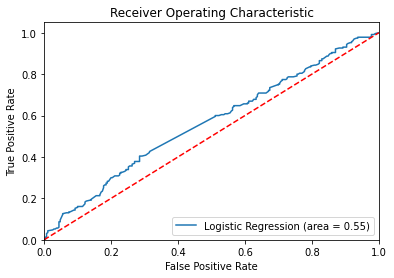

In [18]:
get_lr_model_roc_curve_log(
    chrome_mobile_model, chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], show=False)


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

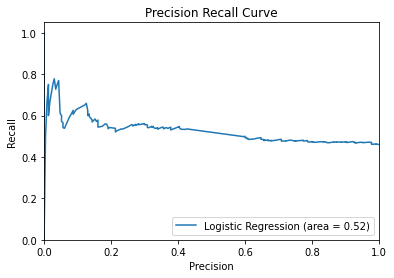

In [19]:
get_lr_model_precision_recall_curve(
    chrome_mobile_model, chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], show=False)


In [20]:
# chrome_mobile_model

In [21]:
# chrome_mobile_view_model = train_logistic_model(
#     chrome_mobile_view_dict['train_x'], chrome_mobile_view_dict['train_y'], chrome_mobile_view_dict['val_x'], chrome_mobile_view_dict['val_y'])


In [22]:
# facebook_model = train_logistic_model(
#     facebook_dict['train_x'], facebook_dict['train_y'], facebook_dict['val_x'], facebook_dict['val_y'])


In [23]:
# samsung_internet_model = train_logistic_model(
#     samsung_internet_dict['train_x'], samsung_internet_dict['train_y'], samsung_internet_dict['val_x'], samsung_internet_dict['val_y'])


In [24]:
platform_6_model = train_logistic_model(
    platform_6_dict['train_x'], platform_6_dict['train_y'], platform_6_dict['val_x'], platform_6_dict['val_y'])


In [25]:
get_lr_model_evaluation(
    platform_6_model, platform_6_dict['val_x'], platform_6_dict['val_y'], platform_6_dict['test_x'], platform_6_dict['test_y'], True)


Validation Accuracy : 0.5339366515837104
Validation Confusion Matrix:
[[111   6]
 [ 97   7]]
--------------------------------------------------
Test Accuracy : 0.5365853658536586
Test Confusion Matrix:
[[61  6]
 [51  5]]


(0.5339366515837104,
 array([[111,   6],
        [ 97,   7]], dtype=int64),
 0.5365853658536586,
 array([[61,  6],
        [51,  5]], dtype=int64))

In [26]:
get_lr_params(platform_6_model)


{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': True}

In [27]:
get_lr_features(platform_6_model, platform_6_dict['val_x'])


,Feature,Score
1,hour,9.913679e-03
0,experiment,6.955083e-03
6,day,6.805566e-03
2,device_make,2.720043e-03
5,month,-6.707026e-07
4,year,-1.935456e-04
3,browser,-3.212963e-03


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

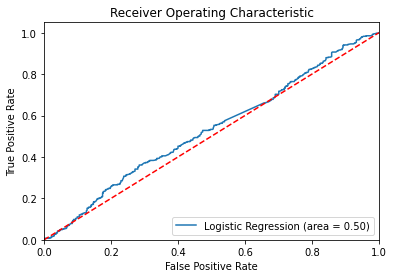

In [28]:
get_lr_model_roc_curve_log(
    platform_6_model, platform_6_dict['train_x'], platform_6_dict['train_y'], show=False)


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

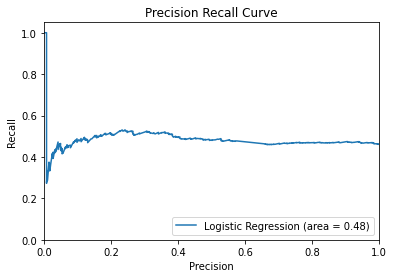

In [29]:
get_lr_model_precision_recall_curve(
    platform_6_model, platform_6_dict['train_x'], platform_6_dict['train_y'], show=False)


## Decision Trees

In [30]:
chrome_mobile_tree_model = train_decision_tree(
    chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'])

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


In [31]:
get_score_df(chrome_mobile_tree_model)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1584,0.002927,0.000258,0.002401,0.000697,None,gini,14,sqrt,1,2,"{'class_weight': None, 'criterion': 'gini', 'm...",0.59,0.62,0.56,0.55,0.54,0.572,0.029257,1
1656,0.004731,0.000836,0.002105,0.000464,None,gini,14,log2,1,2,"{'class_weight': None, 'criterion': 'gini', 'm...",0.59,0.62,0.56,0.55,0.54,0.572,0.029257,1
3173,0.002304,0.000404,0.001368,0.000520,None,entropy,13,sqrt,1,7,"{'class_weight': None, 'criterion': 'entropy',...",0.60,0.60,0.54,0.55,0.52,0.562,0.032496,3
3245,0.004486,0.001780,0.002647,0.001391,None,entropy,13,log2,1,7,"{'class_weight': None, 'criterion': 'entropy',...",0.60,0.60,0.54,0.55,0.52,0.562,0.032496,3
3026,0.002235,0.000417,0.001191,0.000405,None,entropy,12,sqrt,1,4,"{'class_weight': None, 'criterion': 'entropy',...",0.57,0.60,0.56,0.57,0.51,0.562,0.029257,5


In [32]:
get_model_best_estimator(chrome_mobile_tree_model)

DecisionTreeClassifier(max_depth=14, max_features='sqrt', random_state=42)

In [33]:
get_model_best_score(chrome_mobile_tree_model)


0.5720000000000001

In [34]:
get_model_evaluation(chrome_mobile_tree_model, chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'], chrome_mobile_dict['test_x'], chrome_mobile_dict['test_y'], True)


Validation Accuracy : 0.528
Validation Confusion Matrix:
[[47 24]
 [35 19]]
--------------------------------------------------
Test Accuracy : 0.6142857142857143
Test Confusion Matrix:
[[29 11]
 [16 14]]


(0.528,
 array([[47, 24],
        [35, 19]], dtype=int64),
 0.6142857142857143,
 array([[29, 11],
        [16, 14]], dtype=int64))

In [35]:
get_features(chrome_mobile_tree_model, chrome_mobile_dict['val_x'])


,Feature,Score
0,experiment,0.006977
1,hour,0.006977
2,device_make,0.006977
3,platform_os,0.006977
4,year,0.006977
5,month,0.006977
6,day,0.006977


In [36]:
get_best_model_parameters(chrome_mobile_tree_model)


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 14,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

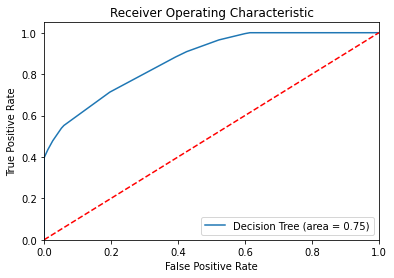

In [37]:
get_model_roc_curve_log(
    chrome_mobile_tree_model, chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'],"Decision Tree", show=False)


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

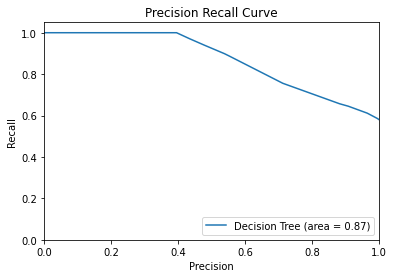

In [38]:
get_model_precision_recall_curve(
    chrome_mobile_tree_model, chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], "Decision Tree", show=False)


In [39]:
# chrome_mobile_view_tree_model = train_decision_tree(
#     chrome_mobile_view_dict['train_x'], chrome_mobile_view_dict['train_y'], chrome_mobile_view_dict['val_x'], chrome_mobile_view_dict['val_y'])


In [40]:
# facebook_tree_model = train_decision_tree(
#     facebook_dict['train_x'], facebook_dict['train_y'], facebook_dict['val_x'], facebook_dict['val_y'])


In [41]:
# samsung_internet_tree_model = train_decision_tree(
#     samsung_internet_dict['train_x'], samsung_internet_dict['train_y'], samsung_internet_dict['val_x'], samsung_internet_dict['val_y'])


In [42]:
platform_6_tree_model = train_decision_tree(
    platform_6_dict['train_x'], platform_6_dict['train_y'], platform_6_dict['val_x'], platform_6_dict['val_y'])


Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


In [43]:
get_score_df(platform_6_tree_model)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
184,0.002386,0.000380,0.001450,0.000458,None,gini,4,sqrt,6,2,"{'class_weight': None, 'criterion': 'gini', 'm...",0.576271,0.59887,0.545455,0.534091,0.579545,0.566846,0.02369,1
185,0.004406,0.002877,0.002014,0.000881,None,gini,4,sqrt,6,3,"{'class_weight': None, 'criterion': 'gini', 'm...",0.576271,0.59887,0.545455,0.534091,0.579545,0.566846,0.02369,1
186,0.004318,0.002126,0.001939,0.000631,None,gini,4,sqrt,6,4,"{'class_weight': None, 'criterion': 'gini', 'm...",0.576271,0.59887,0.545455,0.534091,0.579545,0.566846,0.02369,1
187,0.002428,0.000518,0.001502,0.000448,None,gini,4,sqrt,6,5,"{'class_weight': None, 'criterion': 'gini', 'm...",0.576271,0.59887,0.545455,0.534091,0.579545,0.566846,0.02369,1
188,0.003437,0.000739,0.001638,0.000525,None,gini,4,sqrt,6,6,"{'class_weight': None, 'criterion': 'gini', 'm...",0.576271,0.59887,0.545455,0.534091,0.579545,0.566846,0.02369,1


In [44]:
get_model_best_estimator(platform_6_tree_model)


DecisionTreeClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=6,
                       random_state=42)

In [45]:
get_model_best_score(platform_6_tree_model)


0.5668464304057524

In [46]:
get_model_evaluation(platform_6_tree_model,
                     platform_6_dict['val_x'], platform_6_dict['val_y'], platform_6_dict['test_x'], platform_6_dict['test_y'], True)


Validation Accuracy : 0.5384615384615384
Validation Confusion Matrix:
[[103  14]
 [ 88  16]]
--------------------------------------------------
Test Accuracy : 0.5691056910569106
Test Confusion Matrix:
[[60  7]
 [46 10]]


(0.5384615384615384,
 array([[103,  14],
        [ 88,  16]], dtype=int64),
 0.5691056910569106,
 array([[60,  7],
        [46, 10]], dtype=int64))

In [47]:
get_features(platform_6_tree_model, platform_6_dict['val_x'])


,Feature,Score
0,experiment,0.034177
1,hour,0.034177
2,device_make,0.034177
3,browser,0.034177
4,year,0.034177
5,month,0.034177
6,day,0.034177


In [48]:
get_best_model_parameters(platform_6_tree_model)


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 2}

<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

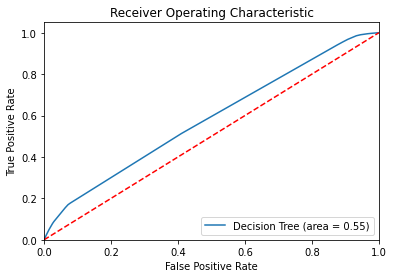

In [49]:
get_model_roc_curve_log(
    platform_6_tree_model, platform_6_dict['train_x'], platform_6_dict['train_y'], "Decision Tree", show=False)


<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

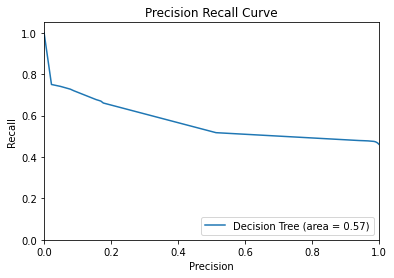

In [50]:
get_model_precision_recall_curve(
    platform_6_tree_model, platform_6_dict['train_x'], platform_6_dict['train_y'], "Decision Tree", show=False)


## XGB Boost

In [15]:
#importing local scripts
sys.path.append(os.path.abspath(os.path.join('..')))
# #Adding scripts path
from scripts.ml_modelling_utils import *
from scripts.model_info_extractor import *
# #importing data_manipulator script


In [13]:
chrome_mobile_xgbc_model = train_xgb_classifier(
    chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'])


Fitting 5 folds for each of 5 candidates, totalling 25 fits


exception calling callback for <Future at 0x1950e607f40 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Python38\lib\site-packages\joblib\externals\loky\process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "C:\Python38\lib\multiprocessing\queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "C:\Python38\lib\site-packages\xgboost\__init__.py", line 9, in <module>
    from .core import DMatrix, DeviceQuantileDMatrix, Booster
  File "C:\Python38\lib\site-packages\xgboost\core.py", line 195, in <module>
    _LIB = _load_lib()
  File "C:\Python38\lib\site-packages\xgboost\core.py", line 178, in _load_lib
    raise XGBoostError(
xgboost.core.XGBoostError: XGBoost Library (xgboost.dll) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dy

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
get_score_df(chrome_mobile_xgbc_model)


In [ ]:
get_model_best_estimator(chrome_mobile_xgbc_model)


In [ ]:
get_model_best_score(chrome_mobile_xgbc_model)


In [ ]:
get_model_evaluation(chrome_mobile_xgbc_model,
                     chrome_mobile_dict['val_x'], chrome_mobile_dict['val_y'], chrome_mobile_dict['test_x'], chrome_mobile_dict['test_y'], True)


In [ ]:
get_features(chrome_mobile_xgbc_model, chrome_mobile_dict['val_x'])


In [ ]:
get_best_model_parameters(chrome_mobile_xgbc_model)


In [ ]:
get_model_roc_curve_log(
    chrome_mobile_xgbc_model, chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], "XGB Classifier", show=False)


In [ ]:
get_model_precision_recall_curve(
    chrome_mobile_xgbc_model, chrome_mobile_dict['train_x'], chrome_mobile_dict['train_y'], "XGB Classifier", show=False)


## Too Much Compution Time Required to train xgb classifier with these parameters

In [ ]:
# chrome_mobile_view_xgbc_model = train_xgb_classifier(
#     chrome_mobile_view_dict['train_x'], chrome_mobile_view_dict['train_y'], chrome_mobile_view_dict['val_x'], chrome_mobile_view_dict['val_y'])


In [ ]:
# facebook_xgbc_model = train_xgb_classifier(
#     facebook_dict['train_x'], facebook_dict['train_y'], facebook_dict['val_x'], facebook_dict['val_y'])


In [ ]:
# samsung_internet_xgbc_model = train_xgb_classifier(
#     samsung_internet_dict['train_x'], samsung_internet_dict['train_y'], samsung_internet_dict['val_x'], samsung_internet_dict['val_y'])


In [ ]:
# platform_6_xgbc_model = train_xgb_classifier(
#     platform_6_dict['train_x'], platform_6_dict['train_y'], platform_6_dict['val_x'], platform_6_dict['val_y'])
